In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

import sklearn.metrics
import scipy.io

In [43]:
def timeAverage(activations,  layer):
        dimension = np.shape(activations)
        if 'fc6' != layer:
            curr = np.mean(activations, axis = 2) #Average across time - current dimensions are [num_stim, frequency, time, kernels]
            curr = np.reshape(curr, (dimension[0], dimension[1] * dimension[3]))
        else:
            curr = activations
        return curr

In [44]:
dimensions = {}
for layer in ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    dimensions[layer] = np.shape(acts[0]['timestep_results'][0]['noisy_repr_dict'][layer])

NameError: name 'acts' is not defined

In [45]:
def runPcaDecomp(avg_across_reps, n_pcs, return_s = False):
    """
    decomposes voxel matrix into IC voxel weights and IC response profiles; i.e.,

      (n_voxels, n_stim)  = (n_voxels, n_pcs) x (n_pcs, n_stim)
      avg_across_reps     = voxel_weights_on_each_IC x IC_response_profiles.T

    0) runs pca [svd] to reduce dimensionality to given subspace
    1) projects data into subspace
    2) runs ica [fastica] in that subspace

    returns: ica_response_profiles, ica_voxel_weights
    <n_pcs> determines the size of the PC subspace to project the data into before 
      running ICA
      -- if integer, use that number of PCs
      -- if None -- then use <self.n_pcs_for_ica>

    note: not integrated with the CV PCA -- you should run that first to get a sense of
      the number of reliable PCs in your data
    todo:
    -- implement sam's ica algorithm?
    """

    # GET LOWER-D PROJECTION OF DATA #
    # n_vox x n_stim

    n, d = avg_across_reps.shape
    # U: n_vox x n_vox
    U, s, _ = np.linalg.svd(avg_across_reps, full_matrices=False) 

    # pcs: n_stim x n_pcs
    pcs = U[:,:n_pcs]
    
    var_explained_each_pc = s**2.0 / np.sum(s**2.0)
    var_explained_by_subspace = np.sum(var_explained_each_pc[:n_pcs])
    print("using %d pcs; explaining %0.1f%% of the variance" % (n_pcs, var_explained_by_subspace * 100.0))
    if return_s:
        s = s[:n_pcs]
        return pcs,s
    return pcs

In [46]:
def cool(x):
    return plt.cm.cool((np.clip(x,2,10)-2)/8.)

In [134]:

def plotCumSVS(layers, act_path, title, timestep, clean = False):
    with h5py.File(act_path, 'r') as f_in:
        
        color_range = range(len(layers))
        for ii, layer in enumerate(layers):
            if clean: 
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_clean_activations'],  layer)
            else:
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_activations'],  layer)
            activations_demeaned = (activation - np.mean(activation, axis = 1, keepdims = True))
            print(np.shape(activations_demeaned))
            pcs_net, s_net = runPcaDecomp(activations_demeaned,500, True)

            x = np.linspace(0, 10)
            colors  = cool(x)[::-1][0:41]
            plt.plot(np.cumsum(s_net**2)/np.sum(s_net**2), 'm', label=layer,c =(colors[color_range[ii]*4][0:3]))
            plt.title(title)
            plt.plot(range(500),np.linspace(0,1,500), 'k')

            plt.ylim(0,1)
            plt.xlim(0,500)
            #print sklearn.metrics.auc(range(1,166), np.cumsum(s_net**2)/np.sum(s_net**2))

        #plt.plot(np.cumsum(spectemp**2)/np.sum(spectemp**2), label='spectemp',c ='k')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

In [83]:
act_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
files = os.listdir(act_path)
print(files)
with h5py.File(act_path+'Babble8Spkr_snr0.hdf5', 'r') as f_in:
    print(f_in.keys())

['Babble8Spkr_snr-3.hdf5', 'AudScene_snr0.hdf5', 'pinkNoise_snr-9.hdf5', 'Babble8Spkr_snr-9.hdf5', 'AudScene_snr-3.hdf5', 'pinkNoise_snr3.hdf5', 'AudScene_snr-6.hdf5', 'Babble8Spkr_snr-6.hdf5', 'pinkNoise_snr-6.hdf5', 'AudScene_snr-9.hdf5', 'pinkNoise_snr0.hdf5', 'Babble8Spkr_snr3.hdf5', 'AudScene_snr3.hdf5', 'pinkNoise_snr-3.hdf5', 'Babble8Spkr_snr0.hdf5']
<KeysViewHDF5 ['0_clean_logits', '0_clean_output', '0_logits', '0_output', '0_reconstructions', '1_clean_logits', '1_clean_output', '1_logits', '1_output', '1_reconstructions', '2_clean_logits', '2_clean_output', '2_logits', '2_output', '2_reconstructions', '3_clean_logits', '3_clean_output', '3_logits', '3_output', '3_reconstructions', '4_clean_logits', '4_clean_output', '4_logits', '4_output', '4_reconstructions', 'clean_correct', 'conv1_0_activations', 'conv1_0_clean_activations', 'conv1_1_activations', 'conv1_1_clean_activations', 'conv1_2_activations', 'conv1_2_clean_activations', 'conv1_3_activations', 'conv1_3_clean_activatio

(566, 12864)
using 165 pcs; explaining 100.0% of the variance
(566, 8704)
using 165 pcs; explaining 93.9% of the variance
(566, 8704)
using 165 pcs; explaining 84.2% of the variance
(566, 17408)
using 165 pcs; explaining 70.2% of the variance
(566, 8704)
using 165 pcs; explaining 58.6% of the variance


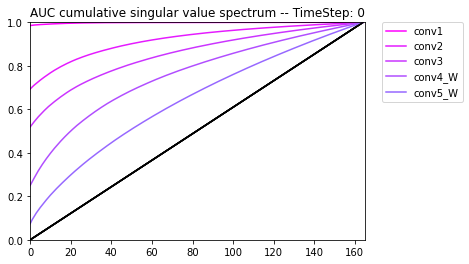

In [57]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
plotCumSVS(layers, acts_path + 'Babble8Spkr_snr0.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: 0', 0)

(566, 12864)
using 165 pcs; explaining 99.9% of the variance
(566, 8704)
using 165 pcs; explaining 95.3% of the variance
(566, 8704)
using 165 pcs; explaining 89.0% of the variance
(566, 17408)
using 165 pcs; explaining 77.9% of the variance
(566, 8704)
using 165 pcs; explaining 58.1% of the variance


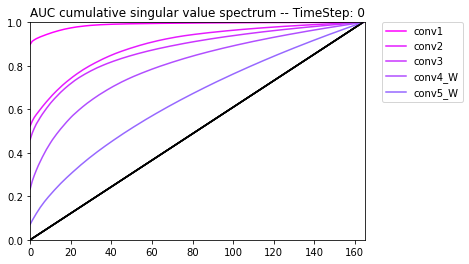

In [58]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
plotCumSVS(layers, acts_path + 'Babble8Spkr_snr0.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: 0', 0, clean= True)

In [135]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    plotCumSVS(layers, acts_path + 'Babble8Spkr_snr-9.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep)

KeyboardInterrupt: 

In [ ]:
# Look at correct versus incorrect 

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.8% of the variance
(566, 8704)
using 500 pcs; explaining 99.2% of the variance
(566, 17408)
using 500 pcs; explaining 98.0% of the variance
(566, 8704)
using 500 pcs; explaining 96.0% of the variance


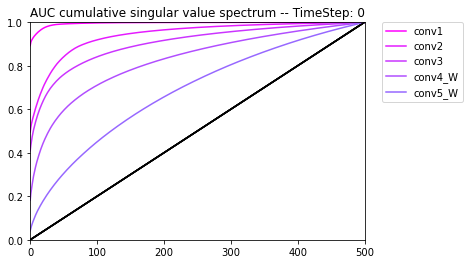

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.2% of the variance
(566, 8704)
using 500 pcs; explaining 96.1% of the variance


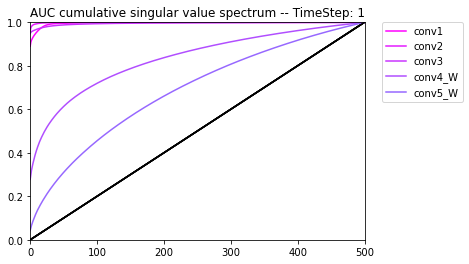

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.4% of the variance
(566, 8704)
using 500 pcs; explaining 96.2% of the variance


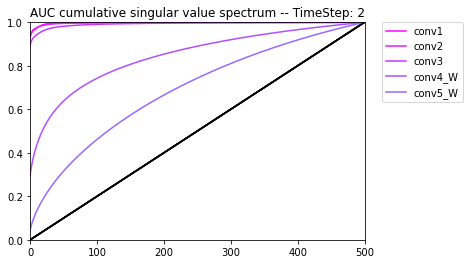

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.6% of the variance
(566, 8704)
using 500 pcs; explaining 96.3% of the variance


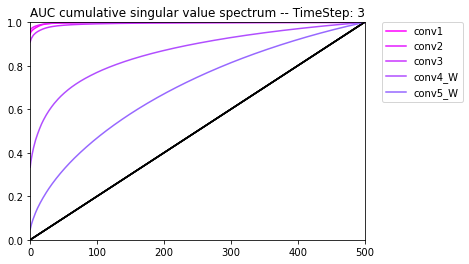

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 17408)
using 500 pcs; explaining 98.8% of the variance
(566, 8704)
using 500 pcs; explaining 96.3% of the variance


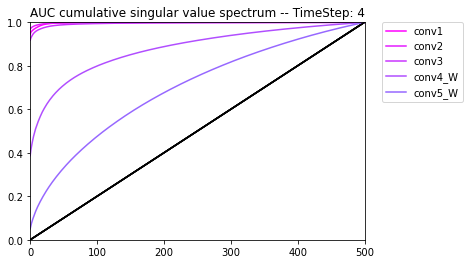

In [85]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    plotCumSVS(layers, acts_path + 'Babble8Spkr_snr-9.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep, clean=True)

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.8% of the variance
(566, 8704)
using 500 pcs; explaining 99.2% of the variance
(566, 17408)
using 500 pcs; explaining 98.0% of the variance
(566, 8704)
using 500 pcs; explaining 96.0% of the variance


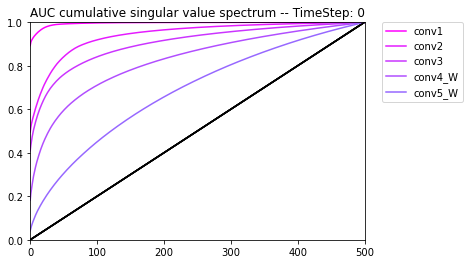

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.8% of the variance
(566, 17408)
using 500 pcs; explaining 98.1% of the variance
(566, 8704)
using 500 pcs; explaining 96.1% of the variance


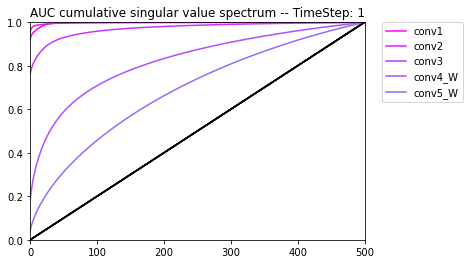

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 17408)
using 500 pcs; explaining 98.2% of the variance
(566, 8704)
using 500 pcs; explaining 96.2% of the variance


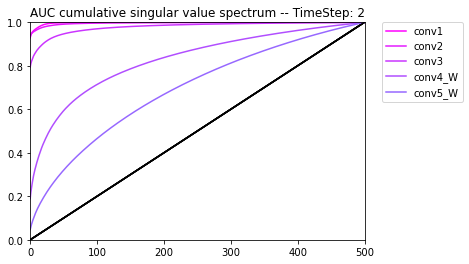

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 17408)
using 500 pcs; explaining 98.3% of the variance
(566, 8704)
using 500 pcs; explaining 96.3% of the variance


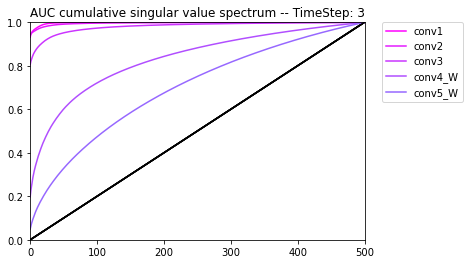

(566, 12864)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 100.0% of the variance
(566, 8704)
using 500 pcs; explaining 99.9% of the variance
(566, 17408)
using 500 pcs; explaining 98.4% of the variance
(566, 8704)
using 500 pcs; explaining 96.4% of the variance


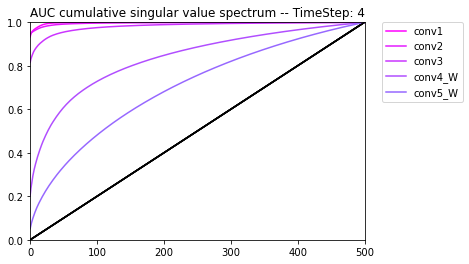

In [86]:
acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_noisy/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    plotCumSVS(layers, acts_path + 'Babble8Spkr_snr-9.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: '+str(timestep), timestep, clean=True)

In [ ]:
cts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
for timestep in range(5):
    plotCumSVS(layers, acts_path + 'Babble8Spkr_snr.hdf5',  'AUC cumulative singular value spectrum -- TimeStep: 0', timestep)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


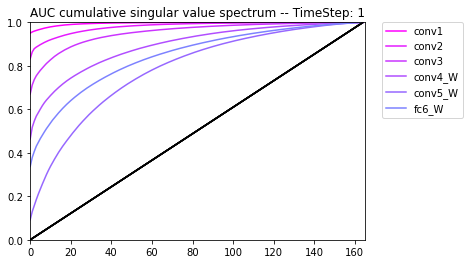

In [58]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 1)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


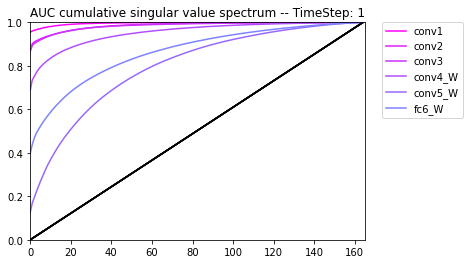

In [59]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 2)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


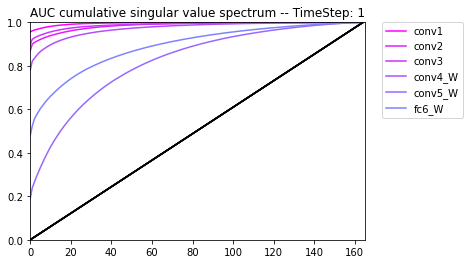

In [61]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 3)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


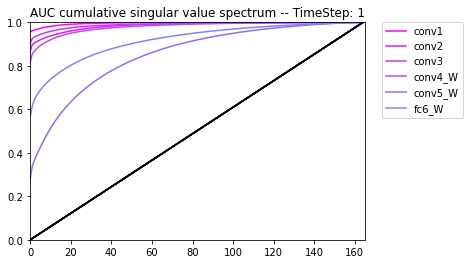

In [62]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 4)

In [125]:
def plotSummary(layers, act_path, title, timestep, clean=False):
    color_range = range(len(layers))
    with h5py.File(act_path, 'r') as f_in:
        to_plot = []
        color_range = range(len(layers))
        for ii, layer in enumerate(layers):
            if clean: 
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_clean_activations'],  layer)
            else:
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_activations'],  layer)
            activations_demeaned = activation - np.mean(activation, axis = 1, keepdims = True)
            pcs_net, s_net = runPcaDecomp(activations_demeaned, 500, True)
            
            to_plot.append(sklearn.metrics.auc(range(1,501), np.cumsum(s_net**2)/np.sum(s_net**2))/(500.))
           # x = np.linspace(0, 10)
           # colors  = cool(x)[::-1][0:41]

            #plt.title(title)
           # plt.bar(ii, sklearn.metrics.auc(range(1,166), np.cumsum(s_net**2)/np.sum(s_net**2))/(165.), align='center', alpha=0.5)

    return to_plot
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.xticks(range(len(layers)), layers, rotation = 75)
    #plt.ylim(0,1)
    #plt.show()

In [126]:

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
to_plot = []
for timestep in range(5):

    layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
    to_plot.append(plotSummary(layers, acts_path + 'Babble8Spkr_snr-9.hdf5', 'AUC cumulative singular value spectrum -- Time step: '+ str(timestep), timestep))

using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 99.7% of the variance
using 500 pcs; explaining 98.7% of the variance
using 500 pcs; explaining 96.9% of the variance
using 500 pcs; explaining 96.2% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 98.9% of the variance
using 500 pcs; explaining 96.3% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 99.1% of the variance
using 500 pcs; explaining 96.5% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 100.0% of the variance
using 500 pcs; explaining 99.4% of the variance
using 500 pcs; explaining 96.6% of the variance
using 500 pcs; explaining 100.

In [127]:
import configs

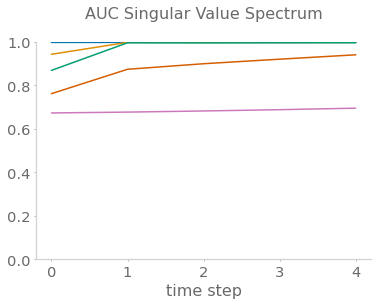

In [133]:
to_plot = np.array(to_plot)
for ii in range(5):
    plt.plot(range(len(to_plot[:,ii])), to_plot[:,ii], label = layers[ii])
    
    plt.title('AUC Singular Value Spectrum\n')
    plt.xlabel('time step')
    plt.ylim(0,1)

In [119]:
def participationRatio(layers, act_path, title, timestep, clean=False):
    color_range = range(len(layers))
    with h5py.File(act_path, 'r') as f_in:
        to_plot = []
        color_range = range(len(layers))
        for ii, layer in enumerate(layers):
            if clean: 
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_clean_activations'],  layer)
            else:
                activation = timeAverage(f_in[layer+'_'+str(timestep)+'_activations'],  layer)
            activations_demeaned = activation - np.mean(activation, axis = 1, keepdims = True)
            pcs_net, s = runPcaDecomp(activations_demeaned, 500, True)
            var_explained_each_pc = s**2.0 / np.sum(s**2.0)
            participationRatio = np.sum(var_explained_each_pc)**2/ np.sum(var_explained_each_pc**2)
            to_plot.append(participationRatio)
            print(to_plot)
        return to_plot
            

In [120]:

acts_path = '/mnt/smb/locker/abbott-locker/hcnn/activations_pnet_all/'
to_plot = []
for timestep in range(5):

    layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W']
    to_plot.append(participationRatio(layers, acts_path + 'Babble8Spkr_snr-9.hdf5', 'AUC cumulative singular value spectrum -- Time step: '+ str(timestep), timestep))

using 500 pcs; explaining 100.0% of the variance
[1.0262834620642196]
using 500 pcs; explaining 99.7% of the variance
[1.0262834620642196, 2.1907357360955193]
using 500 pcs; explaining 98.7% of the variance
[1.0262834620642196, 2.1907357360955193, 4.655976356592078]
using 500 pcs; explaining 96.9% of the variance
[1.0262834620642196, 2.1907357360955193, 4.655976356592078, 23.2271397615487]
using 500 pcs; explaining 96.2% of the variance
[1.0262834620642196, 2.1907357360955193, 4.655976356592078, 23.2271397615487, 201.43502069473334]
using 500 pcs; explaining 100.0% of the variance
[1.0268859726813513]
using 500 pcs; explaining 100.0% of the variance
[1.0268859726813513, 1.0222947141286771]
using 500 pcs; explaining 100.0% of the variance
[1.0268859726813513, 1.0222947141286771, 1.0334458362346073]
using 500 pcs; explaining 98.9% of the variance
[1.0268859726813513, 1.0222947141286771, 1.0334458362346073, 3.9120336565338363]
using 500 pcs; explaining 96.3% of the variance
[1.02688597268

In [110]:
np.cumsum?

In [116]:
print(to_plot)

[201.43502069 194.74036926 184.00460362 170.18344671 152.42303337]


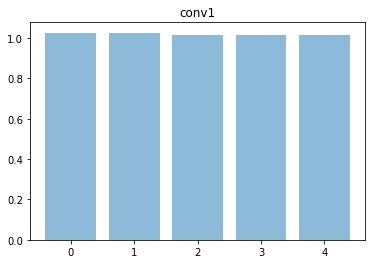

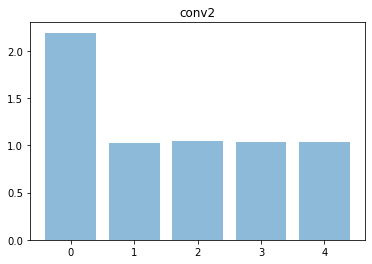

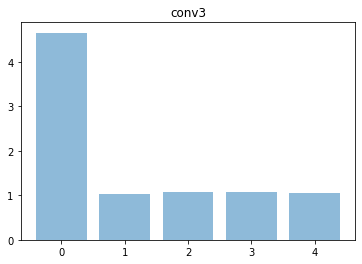

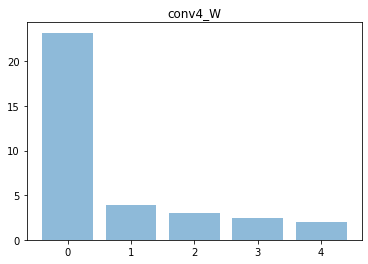

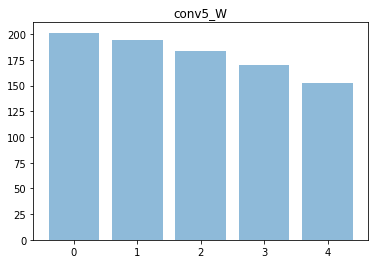

In [122]:
to_plot = np.array(to_plot)
for ii in range(5):
    plt.bar(range(len(to_plot[:,ii])), to_plot[:,ii], align='center', alpha=0.5)
    
    plt.title(layers[ii])
    #plt.ylim(0,1)
    plt.show()

In [ ]:
## MAKE A LINE PLOT

## CORRECT VERSUS INCORRECT SPEECH -- SAME ANALYSIS